# Variational Auto-Encoder (VAE)

### Zhenwen Dai (2019-04-23)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference
%matplotlib inline
from pylab import *

## Load a toy dataset

In [2]:
import GPy
data = GPy.util.datasets.oil_100()
Y = data['X']
label = data['Y'].argmax(1)

In [3]:
N, D = Y.shape

## Model Defintion

In [4]:
Q = 2

In [5]:
H = 50
encoder = nn.HybridSequential(prefix='encoder_')
with encoder.name_scope():
    encoder.add(nn.Dense(H, in_units=D, activation="tanh", flatten=False))
    encoder.add(nn.Dense(H, in_units=H, activation="tanh", flatten=False))
    encoder.add(nn.Dense(Q, in_units=H, flatten=False))
encoder.initialize(mx.init.Xavier(magnitude=3))

In [6]:
H = 50
decoder = nn.HybridSequential(prefix='decoder_')
with decoder.name_scope():
    decoder.add(nn.Dense(H, in_units=Q, activation="tanh", flatten=False))
    decoder.add(nn.Dense(H, in_units=H, activation="tanh", flatten=False))
    decoder.add(nn.Dense(D, in_units=H, flatten=False))
decoder.initialize(mx.init.Xavier(magnitude=3))

In [7]:
from mxfusion.components.variables.var_trans import PositiveTransformation
from mxfusion import Variable, Model, Posterior
from mxfusion.components.functions import MXFusionGluonFunction
from mxfusion.components.distributions import Normal
from mxfusion.components.functions.operators import broadcast_to

In [8]:
m = mf.models.Model()
m.N = mf.components.Variable()
m.decoder = MXFusionGluonFunction(decoder, num_outputs=1,broadcastable=True)
m.x = Normal.define_variable(mean=broadcast_to(mx.nd.array([0]), (m.N, Q)),
                             variance=broadcast_to(mx.nd.array([1]), (m.N, Q)), shape=(m.N, Q))
m.f = m.decoder(m.x)
m.noise_var = Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([0.01]))
m.y = Normal.define_variable(mean=m.f, variance=broadcast_to(m.noise_var, (m.N, D)), 
                             shape=(m.N, D))
print(m)

Model (95c68)
Variable (b8df3) = BroadcastToOperator(data=Variable noise_var (873b0))
Variable (36f25) = BroadcastToOperator(data=Variable (399cc))
Variable (6a234) = BroadcastToOperator(data=Variable (2fe44))
Variable x (1696c) ~ Normal(mean=Variable (6a234), variance=Variable (36f25))
Variable f (0d26d) = GluonFunctionEvaluation(decoder_input_0=Variable x (1696c), decoder_dense0_weight=Variable (89315), decoder_dense0_bias=Variable (41eac), decoder_dense1_weight=Variable (b69fe), decoder_dense1_bias=Variable (8e4e6), decoder_dense2_weight=Variable (a99ff), decoder_dense2_bias=Variable (f0361))
Variable y (5f5c3) ~ Normal(mean=Variable f (0d26d), variance=Variable (b8df3))


In [9]:
q = Posterior(m)
q.x_var = Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([1e-6]))
q.encoder = MXFusionGluonFunction(encoder, num_outputs=1, broadcastable=True)
q.x_mean = q.encoder(q.y)
q.x.set_prior(Normal(mean=q.x_mean, variance=broadcast_to(q.x_var, q.x.shape)))
print(q)

Posterior (63197)
Variable x_mean (09eba) = GluonFunctionEvaluation(encoder_input_0=Variable y (5f5c3), encoder_dense0_weight=Variable (81ec2), encoder_dense0_bias=Variable (aa736), encoder_dense1_weight=Variable (3c4ae), encoder_dense1_bias=Variable (1bab5), encoder_dense2_weight=Variable (7b531), encoder_dense2_bias=Variable (84731))
Variable (f88b7) = BroadcastToOperator(data=Variable x_var (fc12e))
Variable x (1696c) ~ Normal(mean=Variable x_mean (09eba), variance=Variable (f88b7))


## Variational Inference

In [10]:
from mxfusion.inference import BatchInferenceLoop, StochasticVariationalInference, GradBasedInference

In [11]:
observed = [m.y]
alg = StochasticVariationalInference(num_samples=3, model=m, posterior=q, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

In [12]:
infr.initialize(y=mx.nd.array(Y))

In [13]:
infr.run(max_iter=2000, learning_rate=1e-2, y=mx.nd.array(Y), verbose=True)

Iteration 201 loss: 1715.0395507812555
Iteration 401 loss: 599.86877441406255
Iteration 601 loss: 177.60995483398438
Iteration 801 loss: -75.347778320312555
Iteration 1001 loss: -213.82623291015625
Iteration 1201 loss: -332.34564208984375
Iteration 1401 loss: -305.57965087890625
Iteration 1601 loss: -577.47900390625585
Iteration 1801 loss: -669.97760009765625
Iteration 2000 loss: -753.83203125234385

## Plot the training data in the latent space

In [14]:
from mxfusion.inference import TransferInference

In [15]:
q_x_mean = q.encoder.gluon_block(mx.nd.array(Y)).asnumpy()

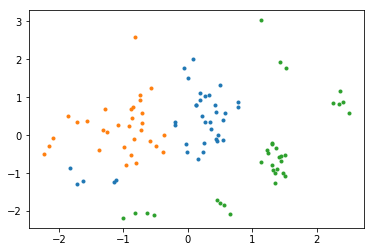

In [16]:
for i in range(3):
    plot(q_x_mean[label==i,0], q_x_mean[label==i,1], '.')